## Keras MLP 

For more information about keras, have a look [here](https://keras.io/).

**Classification**

In [56]:
# setup
%matplotlib notebook
# set this to your working directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['opinion_text'])
pd.to_pickle(X,'X.pkl')
vocab = vectorizer.get_feature_names()
pd.to_pickle(vocab,'vocab.pkl')
Y = df['x_republican']

X.shape

/Users/afra/University/NLP-LSS/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(768, 1000)

In [37]:
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952
3,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817
4,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957


In [38]:
# Getting started with Keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() # create a sequential model
model.add(Dense(50, # output neurons in layer       
          input_dim=X.shape[1], # number of inputs
          activation='relu')) # activation function
model.add(Dense(50, activation='relu')) # hidden layer
model.add(Dense(1, activation='sigmoid')) # output layer
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                50050     
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 52,651
Trainable params: 52,651
Non-trainable params: 0
_________________________________________________________________


You should consider upgrading via the '/Users/afra/University/NLP-LSS/.venv/bin/python -m pip install --upgrade pip' command.


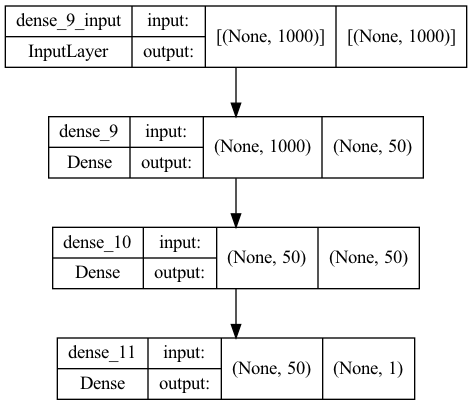

In [39]:
# Visualize a model

# Requires graphviz!

!pip install pydot
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
# fit the model
model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring

In [41]:
model_info = model.fit(X.todense(), Y, 
                      epochs=5,
                      validation_split=.2)

Epoch 1/5
 9/20 [============>.................] - ETA: 0s - loss: 0.8426 - accuracy: 0.7049

2022-03-25 08:45:32.860859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 13ms/step - loss: 0.8036 - accuracy: 0.7150 - val_loss: 0.6545 - val_accuracy: 0.7013
Epoch 2/5
19/20 [===========================>..] - ETA: 0s - loss: 0.2672 - accuracy: 0.8882

2022-03-25 08:45:33.144621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 7ms/step - loss: 0.2662 - accuracy: 0.8876 - val_loss: 0.6309 - val_accuracy: 0.7143
Epoch 3/5
20/20 [==============================] - 0s 8ms/step - loss: 0.1314 - accuracy: 0.9691 - val_loss: 0.7536 - val_accuracy: 0.7662
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0670 - accuracy: 0.9886 - val_loss: 0.6345 - val_accuracy: 0.7532
Epoch 5/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9984 - val_loss: 0.7257 - val_accuracy: 0.7857


In [42]:
# these are the learned coefficients
model.get_weights()

[array([[-0.04506362, -0.05336737,  0.0301922 , ...,  0.03548934,
          0.02991204, -0.07081991],
        [-0.0526585 ,  0.05509777,  0.06981739, ...,  0.06445193,
         -0.04915498,  0.01417119],
        [ 0.05618631,  0.00601225, -0.06870974, ..., -0.043991  ,
         -0.0199902 ,  0.0046391 ],
        ...,
        [-0.06438193,  0.01438804, -0.08280949, ..., -0.04892972,
         -0.08147524,  0.017337  ],
        [ 0.04817421,  0.02060499,  0.05788626, ...,  0.0360634 ,
          0.04494337,  0.05185214],
        [-0.02724953,  0.0544113 , -0.01090194, ...,  0.05345299,
         -0.06220768,  0.05669348]], dtype=float32),
 array([ 1.13272795e-03, -1.04536233e-03,  1.16833276e-03,  1.94965559e-03,
        -6.78547949e-04,  3.73668270e-03, -4.70926240e-03,  1.63830910e-03,
         5.05346386e-03, -5.81229629e-04,  6.47758786e-03, -2.40171282e-03,
        -7.52219511e-03, -1.98727520e-03, -7.79555226e-03, -6.16341550e-03,
         2.90244212e-03,  9.00326180e-04,  8.57814521e

<IPython.core.display.Javascript object>


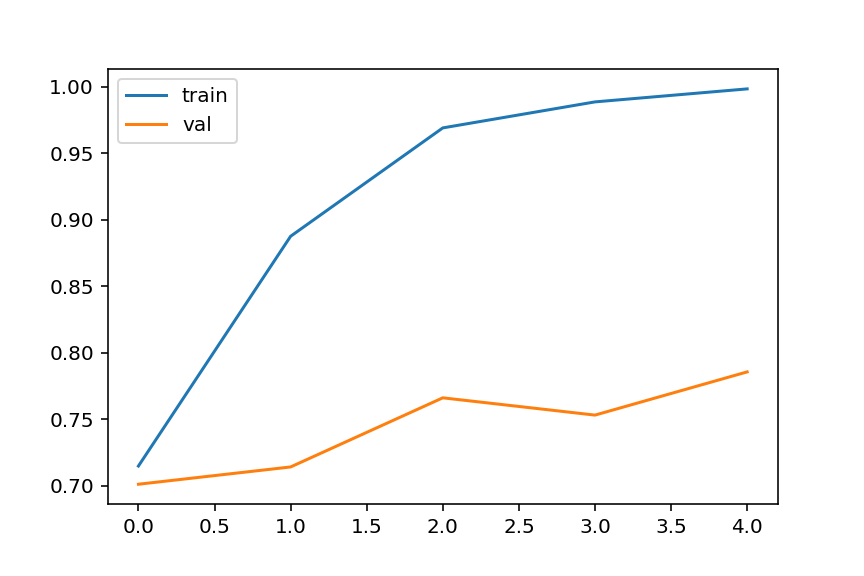

In [43]:
# Plot performance by epoch
plt.plot(model_info.epoch,model_info.history['accuracy'])
plt.plot(model_info.epoch,model_info.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')

In [44]:
# form probability distribution over classes
Ypred_prob = model.predict(X.todense())
print (Ypred_prob.squeeze()[:5])
Ypred = (Ypred_prob > .5).astype(float)
print (Ypred.squeeze()[:5])

[0.14333454 0.98638606 0.98907626 0.9999993  0.98974365]
[0. 1. 1. 1. 1.]


2022-03-25 08:46:18.316618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Save a model
model.save('keras-clf.pkl')

In [ ]:
# load model
from keras.models import load_model
model = load_model('keras-clf.pkl')

**Regression**

In [45]:
# Regression model with R-squared
Yreg = df['log_cite_count']


model = Sequential() # create a sequential model
model.add(Dense(100, # output neurons in layer       
          input_dim=X.shape[1], # number of inputs
          activation='relu')) # activation function
model.add(Dense(50, activation='relu')) # hidden layer
model.add(Dense(1)) # output layer

from keras import backend as K
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss='mean_squared_error', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=[r2]) # compute r-squared
model_info = model.fit(X.todense(), Yreg, 
                      epochs=15)

from sklearn.metrics import r2_score
Ypred = model.predict(X.todense())

print (Yreg[:5], Ypred.squeeze()[:5])
r2_score(Yreg,Ypred.squeeze())


Epoch 1/15
24/24 [==============================] - 0s 5ms/step - loss: 15.0986 - r2: -6.0558
Epoch 2/15
 1/24 [>.............................] - ETA: 0s - loss: 7.9769 - r2: -3.5525

2022-03-25 09:13:20.296065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 5ms/step - loss: 6.0553 - r2: -1.9257
Epoch 3/15
24/24 [==============================] - 0s 4ms/step - loss: 3.5403 - r2: -0.6950
Epoch 4/15
24/24 [==============================] - 0s 5ms/step - loss: 1.9898 - r2: 0.0276
Epoch 5/15
24/24 [==============================] - 0s 5ms/step - loss: 1.1133 - r2: 0.4729
Epoch 6/15
24/24 [==============================] - 0s 4ms/step - loss: 0.7134 - r2: 0.6584
Epoch 7/15
24/24 [==============================] - 0s 4ms/step - loss: 0.5038 - r2: 0.7661
Epoch 8/15
24/24 [==============================] - 0s 5ms/step - loss: 0.5508 - r2: 0.7341
Epoch 9/15
24/24 [==============================] - 0s 5ms/step - loss: 0.7152 - r2: 0.6632
Epoch 10/15
24/24 [==============================] - 0s 5ms/step - loss: 0.9677 - r2: 0.5545
Epoch 11/15
24/24 [==============================] - 0s 6ms/step - loss: 0.9181 - r2: 0.4381
Epoch 12/15
24/24 [==============================] - 0s 5ms/step - loss: 0.7318 - r2: 0

2022-03-25 09:13:22.161833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.8898086245201444

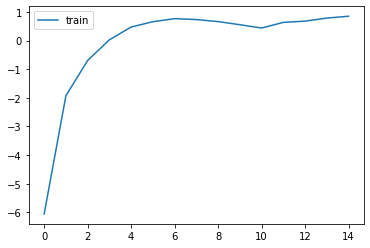

In [47]:
%matplotlib inline

# Plot performance by epoch
plt.plot(model_info.epoch,model_info.history['r2'])
plt.legend(['train', 'val'], loc='best')


## Autoencoders

neural nets that perform domain-specific lossy compression

In [50]:
# Autoencoder

from keras.models import Sequential
from keras.layers import Dense

model = Sequential() # create a sequential model
model.add(Dense(100, # first compression layer       
          input_dim=X.shape[1], # number of inputs
          activation='relu')) # activation function
model.add(Dense(25, activation='relu', name="compression_layer")) # final compression layer layer
model.add(Dense(100, activation='relu')) # first reconstruction layer
model.add(Dense(X.shape[1], activation='relu')) # final reconstruction layer
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               100100    
                                                                 
 compression_layer (Dense)   (None, 25)                2525      
                                                                 
 dense_16 (Dense)            (None, 100)               2600      
                                                                 
 dense_17 (Dense)            (None, 1000)              101000    
                                                                 
Total params: 206,225
Trainable params: 206,225
Non-trainable params: 0
_________________________________________________________________


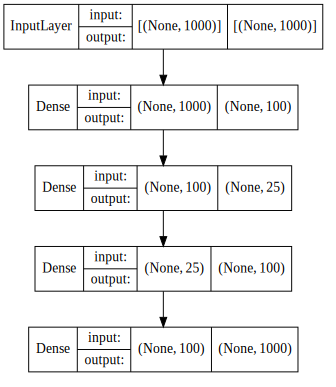

In [51]:
# Visualize a model

# Requires graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model,
                   show_shapes=True,
                   show_layer_names=False,
                   dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [52]:
# fit the model
model.compile(loss='mean_squared_error', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=[r2]) # compute accuracy, for scoring

model_info = model.fit(X.todense(), X.todense(), 
                      epochs=10,
                      validation_split=.2)

Epoch 1/10
 8/20 [===========>..................] - ETA: 0s - loss: 20.7237 - r2: -0.0342

2022-03-25 09:18:28.727574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 17ms/step - loss: 19.8617 - r2: 0.0070 - val_loss: 16.4187 - val_r2: 0.0533
Epoch 2/10
 9/20 [============>.................] - ETA: 0s - loss: 18.7450 - r2: 0.0611

2022-03-25 09:18:29.040704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 9ms/step - loss: 18.5130 - r2: 0.0755 - val_loss: 16.0690 - val_r2: 0.0738
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 18.0250 - r2: 0.1002 - val_loss: 15.7245 - val_r2: 0.0937
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 17.4778 - r2: 0.1273 - val_loss: 15.3691 - val_r2: 0.1141
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 16.9010 - r2: 0.1542 - val_loss: 14.9886 - val_r2: 0.1361
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 16.2107 - r2: 0.1893 - val_loss: 14.6376 - val_r2: 0.1565
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 15.5173 - r2: 0.2283 - val_loss: 14.3165 - val_r2: 0.1755
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 14.8587 - r2: 0.2562 - val_loss: 14.1180 - val_r2: 0.1873
Epoch 9/10
20/20 [==============================] - 0s 8ms/step - loss: 14.1306 - r2: 0.2858 - val_lo

In [53]:
# compress the data

import keras


compression_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("compression_layer").output)
X_compressed = compression_model(X.todense())
print (X_compressed.shape)

(768, 25)


[0.06008335 0.03858287 0.03146097]


/Users/afra/University/NLP-LSS/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


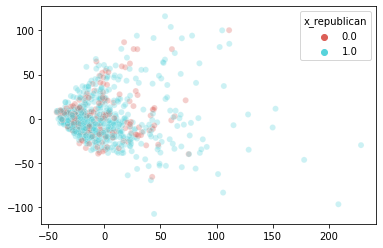

In [54]:
#%% PCA Viz

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# visualize X and X_compressed
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X.todense())
print(pca.explained_variance_ratio_)

sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=Y,
    palette=sns.color_palette("hls", len(set(Y))), alpha=0.3)

plt.show()

[0.34145417 0.11664119 0.09176214]


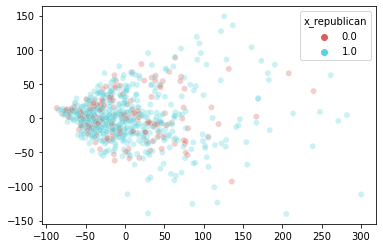

In [55]:
# visualize X and X_compressed
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X_compressed)
print(pca.explained_variance_ratio_)


sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=Y,
    palette=sns.color_palette("hls", len(set(Y))), alpha=0.3)
plt.show()